# Lab 2 - Creating Entanglement with Qiskit

This lab demonstrates interesting properties of *entangled* qubits. In particular, we will consider two experiments:
- **CHSH Inequality Violation** - this shows that quantum mechanics *cannot* be explained by a local hidden variable theory
- **Teleportation** - teleport an arbitrary quantum state using an entangled qubit pair as a resource

In particular, this lab demonstrates how to use new features from IBM Quantum 
- **Primitives** - abstract measurement and error mitigation for scalable quantum computing
- **Dynamic Circuits** - mid-circuit measurement and feed-forward within the qubits' coherence time

## Getting Started

Start by importing some libraries we need, including the `Sampler` and `Estimator` primitives from Qiskit. While the primitives from `qiskit.providers` use a local statevector simulator by default, the syntax within this lab is easily generalizable to running experiments on real systems.

To run on real hearware requires a Qiskit Runtime service instance. If you haven't done so already, follow the instructions in the Qiskit [Getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up. TODO: include video links and such. After setup, import the `Sampler` and `Estimator` primitives from `qiskit_ibm_runtime` instead. Additionally we will need `QiskitRuntimeService` and `Session`, which form the interface between Qiskit and Qiskit IBM Runtime. Then the below exercises can be run on real systems by instantiating the primitives in this way (as opposed to from `qiskit.primitives`):

```
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator

service = QiskitRuntimeService()
backend = service.get_backend('...')
session = Session(service=service, backend=backend)
sampler = Sampler(session=session)
estimator = Estimator(session=session)
```
where additional options can be specified in the `Sampler` and `Estimator` with the `Options` class. See this [how-to](https://qiskit.org/ecosystem/ibm-runtime/how_to/run_session.html) for using Primitives with Runtime Sessions.


In [1]:
# required import of libraries and modules

# import quantum circuit from IBM's Qiskit circuit module
from qiskit.circuit import QuantumCircuit

# import estimator and sample
# from IBM's Qiskit primitives module
from qiskit.primitives import Estimator, Sampler

# import Sparse Pauli operator
# from IBM's Qiskit quantum information module
from qiskit.quantum_info import SparsePauliOp

# import histogram plotting
# from IBM's Qiskit visualization module
from qiskit.visualization import plot_histogram

# import numpy
import numpy as np

# import plotting from Matplotlib's pyplot module
import matplotlib.pyplot as plt

# OPTIONAL: use the dark background style
# for the plotting from Matplotlib's pyplot module
plt.style.use("dark_background")

## CHSH Inequality Violation

### Warm Up

Create circuits that put the qubit in the excited $|1\rangle$ and superposition $|+\rangle$ states, respectivly, and measure them in different bases. This is done first with the `Sampler` primitive (which is most similar to the `backend.run()` used in the previous lab), and then with the `Estimator` primitive to show how measurement is abstracted in that we do not need to worry about rotating the qubit into the appropriate measurement basis. The primitives will be executed withing the `Session` context which allows efficiency to optimize workloads.

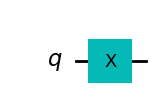

In [2]:
# create an excited state |1>

# create a quantum circuit for one qubit
# and to implement an excited state |1>
qc_1 = QuantumCircuit(1)

# apply a Pauli-X (bit flip / not) gate to
# the quantum circuit, on the 1st qubit
qc_1.x(0)

# draw the quantum circuit implementing
# the excited state |1>
qc_1.draw("mpl")

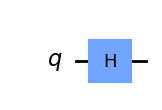

In [3]:
# create quantum superposition state |+>

# create a quantum circuit for one qubit
# and to implement a quantum superposition state |+>
qc_plus = QuantumCircuit(1)

# apply a Hadamard gate to
# the quantum circuit, on the 1st qubit
qc_plus.h(0)

# draw the quantum circuit implementing
# the quantum superposition state |+>
qc_plus.draw("mpl")

### Sampler Primitive

First use the `Sampler` to measure qubits in the $Z$-basis (the physical basis in which qubits are measured). The `Sampler` will count the number of outcomes of the $|0\rangle$ state and $|1\rangle$ state, normalized by the number of shots (experiments performed). The `Sampler` also offers the ability to easily perform error mitigation (which is covered in Lab 5), which modifies this calculation, and hence the outcomes are refered to as *quasi-probabilities*.

Measurments must be present in the circuit when using the `Sampler` primitive. Then the `Session` context is opened, the `Sampler` is instantiated, and `sampler.run()` is used to send the circuits to the backend, similar to the `backend.run()` syntax you may already be familiar with.

In [4]:
# measure all the qubits of
# the quantum circuit implementing
# an excited state |1>
qc_1.measure_all()

# measure all the qubits of
# the quantum circuit implementing
# a quantum superposition state |+>
qc_plus.measure_all()

# create a Sampler object
sampler = Sampler()

# create a job for the quantum circuit implementing
# an excited state |1>, running the Sampler
job_1 = sampler.run(qc_1)

# create a job for the quantum circuit implementing
# a quantum superposition state |+>, running the Sampler
job_plus = sampler.run(qc_plus)

In [5]:
# retrieve the quasi-distribution of
# the job for the quantum circuit
# implementing an excited state |1>
quasi_dists_ket_1 = job_1.result().quasi_dists

# fix the legend issue for
# the quasi-distribution of the outcome 0
quasi_dists_ket_1[0][0] = 1e-20

# show the quasi-distribution of
# the job for the quantum circuit
# implementing an excited state |1>
quasi_dists_ket_1

[{1: 1.0, 0: 1e-20}]

In [6]:
# retrieve the quasi-distribution of
# the job for the quantum circuit implementing
# a quantum superposition state |+>
quasi_dists_ket_plus = job_plus.result().quasi_dists

# show the quasi-distribution of
# the job for the quantum circuit
# implementing a quantum superposition state |+>
quasi_dists_ket_plus

[{0: 0.4999999999999999, 1: 0.4999999999999999}]

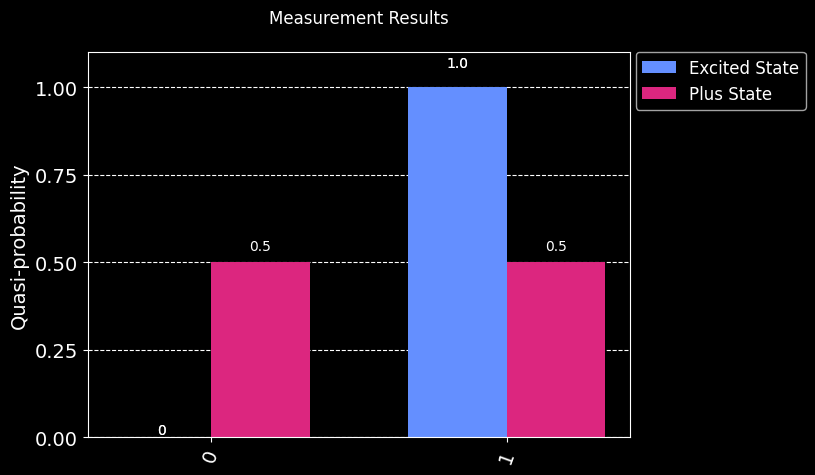

In [7]:
# create the legend for the two quantum states
# created before, namely the excited state |1> and
# the quantum superposition state |+>
legend = ["Excited State", "Plus State"]

# plot the histogram for the quasi-distributions
# for the two quantum states created before,
# namely the excited state |1> and
# the quantum superposition state |+>
plot_histogram( [ quasi_dists_ket_1[0], quasi_dists_ket_plus[0] ],
                  legend=legend, title="Measurement Results\n" )

The result for the excited state is always $|1\rangle$ wheres it is roughly half $|0\rangle$ and half $|1\rangle$ for the plus superposition state. This is because the $|0\rangle$ and $|1\rangle$ states are *eigenstates* of the $Z$ operator (with $+1$ and $-1$ eigenvalues, respectively).

Let's switch and measure in the $X$ basis. Using the `Sampler` we must rotate the qubit from the $X$-basis to the $Z$-basis for measurement (because that is the only basis we can actually perform measurement in).

In [8]:
# remove all the qubits' measurements of
# the quantum circuit implementing
# an excited state |1>
qc_1.remove_final_measurements()

# remove all the qubits' measurements of
# the quantum circuit implementing
# a quantum superposition state |+>
qc_plus.remove_final_measurements()


# prepare the 1st qubit of the quantum circuit
# implementing an excited state |1>,
# for the X-Basis measurement,
# applying a Hadamard gate
qc_1.h(0)

# prepare the 1st qubit of the quantum circuit
# implementing a quantum superposition state |+>,
# for the X-Basis measurement,
# applying a Hadamard gate
qc_plus.h(0)


# measure all the qubits of
# the quantum circuit implementing
# an excited state |1>
qc_1.measure_all()

# measure all the qubits of
# the quantum circuit implementing
# a quantum superposition state |+>
qc_plus.measure_all()

In [9]:
# create a Sampler object
sampler = Sampler()

# create a job for the quantum circuit implementing
# an excited state |1>, running the Sampler
job_1 = sampler.run(qc_1)

# create a job for the quantum circuit implementing
# a quantum superposition state |+>, running the Sampler
job_plus = sampler.run(qc_plus)

In [10]:
# retrieve the quasi-distribution of
# the job for the quantum circuit
# implementing an excited state |1>,
# measured in the X-Basis
quasi_dists_ket_1 = job_1.result().quasi_dists

# show the quasi-distribution of
# the job for the quantum circuit
# implementing an excited state |1>,
# measured in the X-Basis
quasi_dists_ket_1

[{0: 0.4999999999999999, 1: 0.4999999999999999}]

In [11]:
# retrieve the quasi-distribution of
# the job for the quantum circuit
# implementing a quantum superposition state |+>,
# measured in the X-Basis
quasi_dists_ket_plus = job_plus.result().quasi_dists

# fix the legend issue for
# the quasi-distribution of the outcome 1
quasi_dists_ket_plus[0][1] = 1e-20

# show the quasi-distribution of
# the job for the quantum circuit
# implementing a quantum superposition state |+>,
# measured in the X-Basis
quasi_dists_ket_plus

[{0: 0.9999999999999996, 1: 1e-20}]

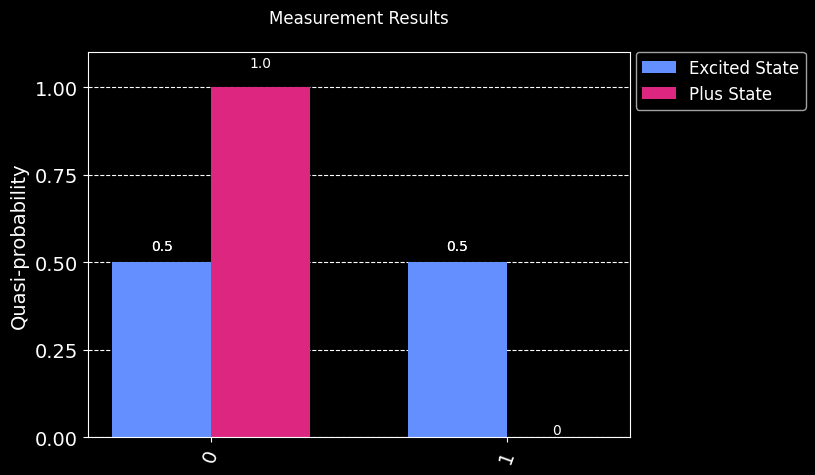

In [12]:
# plot the histogram for the quasi-distributions
# for the two quantum states created before,
# namely the excited state |1> and
# the quantum superposition state |+>,
# measured in the X-Basis
plot_histogram( [ quasi_dists_ket_1[0], quasi_dists_ket_plus[0] ],
                  legend=legend, title="Measurement Results\n" )

Now we see the opposite: the plus superposition always give the 1 result, hence an eigenstate of the $X$ operator, whereas the excited $|1\rangle$ yields a roughtly fifty-fifty split. The $|+\rangle$ and $|-\rangle$ states are eigenstates of the $X$ operator, with eigenvalues $+1$ and $-1$, respectively. This is good to remember when considering how the `Estimator` works in the next subsection. 

### Estimator Primitive

The Qiskit Runtime Primitives allow us to abstract measurement into the `Estimator` primitive, where it is specified as an *observable*. In particular, we can construct the same circuits, the excited $|1\rangle$ and superposition $|+\rangle$ as before. However, in the case of the `Estimator`, we *do not* add measurements to the circuit. Instead, specify a list of observables which take the form of Pauli strings. In our case for a measurement of a single qubit, we specify `'Z'` for the $Z$-basis and `'X'` for the $X$-basis.

In [13]:
# create a quantum circuit for one qubit
# and to implement an excited state |1>
qc2_1 = QuantumCircuit(1)

# apply a Pauli-X (bit flip / not) gate to
# the quantum circuit, on the 1st qubit
qc2_1.x(0)


# create a quantum circuit for one qubit
# and to implement a quantum superposition state |+>
qc2_plus = QuantumCircuit(1)

# apply a Hadamard gate to
# the quantum circuit, on the 1st qubit
qc2_plus.h(0)


# create a list for the observables for
# the Sparse Pauli-Z and Pauli-X operators
obsvs = list( SparsePauliOp( [ "Z", "X" ] ) )

In [14]:
# crate an Estimator object
estimator = Estimator()

# create a job for the quantum circuit implementing
# an excited state |1>, running the Estimator
job2_1 = estimator.run( [ qc2_1 ] * len(obsvs), observables=obsvs )

# create a job for the quantum circuit implementing
# a quantum superposition state |+>, running the Estimator
job2_plus = estimator.run( [ qc2_plus ] * len(obsvs), observables=obsvs )

In [16]:
# print a table with results (and eigenvalues) for
# the quantum states created before and measured in the bases set before
print(f'    |   <Z>   |   <X> ')
print(f'----|-------------------------------')
print(f'|1> | {job2_1.result().values[0]}    | {job2_1.result().values[1]}')
print(f'|+> |  {job2_plus.result().values[0]}    | {job2_plus.result().values[1]}')

    |   <Z>   |   <X> 
----|-------------------------------
|1> | -1.0    | 0.0
|+> |  0.0    | 0.9999999999999998


Just as before, we see the $|1\rangle$ state expectation in the $Z$-basis is $-1$ (corresponding to its eigenvalue) and around zero in the $X$-basis (average over $+1$ and $-1$ eigenvalues), and vice-versa for the $|+\rangle$ state (although its eigenvalue of the $X$ operators is $+1$).

## CHSH Inequality

Imagine Alice and Bob are given each one part of a bipartite entangled system. Each of them then performs two measurements on their part in two different bases. Let's call Alice's bases A and a and Bob's B and b. What is the expectation value of the quantity 

$$
\langle CHSH \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle ?
$$

Now, Alice and Bob have one qubit each, so any measurement they perform on their system (qubit) can only yield one of two possible outcomes: +1 or -1. Note that whereas we typically refer to the two qubit states as $|0\rangle$ and $|1\rangle$, these are eigenstates, and a projective measurement will yield their eigenvalues, +1 and -1, respectively.

Therefore, if any measurement of A, a, B, and b can only yield $\pm 1$, the quantities $(B-b)$ and $(B+b)$ can only be 0 or $\pm 2$. And thus, the quantity $A(B-b) + a(B+b)$ can only be either +2 or -2, which means that there should be a bound for the expectation value of the quantity we have called

$$
|\langle CHSH \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \le 2.
$$

Now, the above discussion is oversimplified, because we could consider that the outcome on any set of measurements from Alice and Bob could depend on a set of local hidden variables, but it can be shown with some math that, even when that is the case, the expectation value of the quantity $CHSH$ should be bounded by 2 if local realism held.

But what happens when we do these experiments with an entangled system? Let's try it!

The first step is to build the observable
$$
CHSH = A(B-b) + a(B+b) = AB - Ab + aB +ab
$$
where $A, a$ are each one of $\{IX, IZ\}$ for qubit 0 and $B, b$ are each one of $\{XI, ZI\}$ for qubit 1 (corresponding to little-endian notation). Paulis on different qubits can be composed by specifying order with a Pauli string, for example instantiating a `SparsePauliOp` with the `'ZX'` argument implies a measurement of $\langle X \rangle$ on `q0` and $\langle Z \rangle$ on `q1` . This *tensor* product (combining operations on *different* qubits) can be explicitly stated using the `.tensor()` method. Additionally, combining operations on the *same* qubit(s) uses the *compositional* product with the `.compose()` method. For example, all these statements create the same Pauli operator:

```
from qiskit.quantum_info import SparsePauliOp

ZX = SparsePauliOp('ZX')
ZX = SparsePauliOp(['ZX'], coeffs=[1.]) # extendable to a sum of Paulis
ZX = SparsePauliOp('Z').tensor(SparsePauliOp('X')) # extendable to a tensor product of Paulis
ZX = SparsePauliOp('XZ').compose(SparsePauliOp('YY')) # extendable to a compositional product of Paulis
```


Ex 1 - create an operator for CHSH witness

from qiskit.quantum_info import SparsePauliOp

obsv =  SparsePauliOp.from_list(
    [
        ("IZ", 2.044921875),
        ("ZI", -1.017578125),
        ("ZZ",  2.41796875),
        ("II", 0.18093119978423156),
    ]
) # create operator for chsh witness SparsePauliOp('XX').compose(SparsePauliOp('YX'))

In [17]:
# import the Sparse Pauli operator from
# the IBM's Qiskit quantum information module
from qiskit.quantum_info import SparsePauliOp


# For Alice: A = Z ; a = X
# For Bob: B = Z ; b = X

# create the Sparse Pauli operator ZZ, for <AB>
ZZ = SparsePauliOp.from_list( [ ( "ZZ", 1 ) ] )

# create the Sparse Pauli operator ZX, for <Ab>
ZX = SparsePauliOp.from_list( [ ( "ZX", 1 ) ] )

# create the Sparse Pauli operator XZ, for <aB>
XZ = SparsePauliOp.from_list( [ ( "XZ", 1 ) ] )

# create the Sparse Pauli operator XX, for <ab>
XX = SparsePauliOp.from_list( [ ( "XX", 1 ) ] )


# create the list of required
# operators ZZ, ZX, XZ, and XX
ops = [ ZZ, ZX, XZ, XX ]


# there are two possible CHSH witnesses

# create operator for CHSH witness <CHSH_1>
#     <CHSH_1> = <ZZ> - <ZX> + <XZ> + <XX> (=)
# (=) <CHSH_1> = <AB> - <Ab> + <aB> + <ab>
#obsv = ops[0] - ops[1] + ops[2] + ops[3]

# create operator for CHSH witness <CHSH_2>
#     <CHSH_2> = <ZZ> + <ZX> - <XZ> + <XX> (=)
# (=) <CHSH_2> = <AB> + <Ab> - <aB> + <ab>
obsv = ( ops[0] + ops[1] - ops[2] + ops[3] )

In [18]:
# import the grader for the exercise 1 of the lab 2
from qc_grader.challenges.qgss_2023 import grade_lab2_ex1

# grade the exercise 1 of the lab 2
grade_lab2_ex1( obsv )

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Create Entangled Qubit Pair

Next we want to test the $CHSH$ observable on an entangled pair, for example the maximally-entangled Bell state
$$
|\Phi\rangle = \frac{1}{\sqrt{2}} \left(|00\rangle + |11\rangle \right)
$$
which is created with a Hadamard gate followed by a CNOT with the target on the same qubit as the Hadamard. Due to the simplifaction of measuring in just the $X$- and $Z$-bases as discussed above, we will *rotate* the Bell state around the Bloch sphere which is equivalant to changing the measurement basis as demonstrated in the Warmup section. This can be done by applying an $R_y(\theta)$ gate where $\theta$ is a `Parameter` to be specified at the `Estimator` API call. This produces the state
$$
|\psi\rangle = \frac{1}{\sqrt{2}} \left(\cos(\theta/2) |00\rangle + \sin(\theta/2)|11\rangle \right)
$$

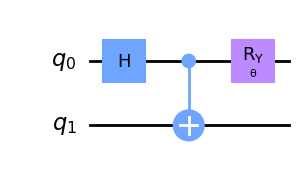

In [19]:
# import the parameter from
# the IBM's Qiskit circuit module
from qiskit.circuit import Parameter

# create a parameter for the theta angle
theta = Parameter("θ")


# create a quantum circuit for two qubits
# and to implement a parametrized quantum entangled pair
qc = QuantumCircuit(2)


# apply a Hadamard gate to
# the quantum circuit, on the 1st qubit
qc.h(0)

# apply a CX/CNOT gate to
# the quantum circuit,
# with control on 1st qubit
# and target on 2nd qubit
qc.cx(0, 1)

# apply a RY (Rotation-Y) gate to
# the quantum circuit, on the 1st qubit,
# with the theta angle defined before
qc.ry(theta, 0)


# draw the quantum circuit implementing
# a parametrized quantum entangled pair
qc.draw("mpl")

Next we need to specify a `Sequence` of `Parameter`s that show a clear violation of the CHSH Inequality, namely 
$$
|\langle CHSH \rangle| > 2.
$$
Let's make sure we have at least three points in violation.

Ex 2 - Create a Parameterization (i.e., list, array) of the angle in the above circuit (in radians)

Hint: Note the `type` for the `parameter_values` argument is `Sequence[Sequence[float]]`.

In [20]:
# create a parameterization of theta angles that
# will violate the CHSH inequality

# number of theta angles to violate the CHSH inequality
number_of_phases = 20


# for the 1st CHSH witness
#     <CHSH_1> = <ZZ> - <ZX> + <XZ> + <XX> (=)
# (=) <CHSH_1> = <AB> - <Ab> + <aB> + <ab>
#phases_chsh_1_1 = np.linspace(0.5 * np.pi, np.pi, number_of_phases)
#phases_chsh_1_2 = np.linspace(1.5 * np.pi, 2 * np.pi, number_of_phases)


# create the two lists of theta angles that
# violate the CHSH inequality
#angles_chsh_1_1 = [[ph] for ph in phases_chsh_1_1]
#angles_chsh_1_2 = [[ph] for ph in phases_chsh_1_2]


# merge the two lists of theta angles that
# violate the CHSH inequality, for the final result
#angles = angles_chsh_1_1 + angles_chsh_1_2



# for the 2nd CHSH witness
#     <CHSH_2> = <ZZ> + <ZX> - <XZ> + <XX> (=)
# (=) <CHSH_2> = <AB> + <Ab> - <aB> + <ab>
phases_chsh_2_1 = np.linspace( 0, ( 0.5 * np.pi ), number_of_phases )
phases_chsh_2_2 = np.linspace( ( 1 * np.pi ) , ( 1.5 * np.pi ), number_of_phases )


# create the two lists of theta angles that
# violate the CHSH inequality
angles_chsh_2_1 = [ [ph] for ph in phases_chsh_2_1 ]
angles_chsh_2_2 = [ [ph] for ph in phases_chsh_2_2 ]


# merge the two lists of theta angles that
# violate the CHSH inequality, for the final result
angles = angles_chsh_2_1 + angles_chsh_2_2

Test your angles and observable by running with the `Estimator` before submitting to the grader.

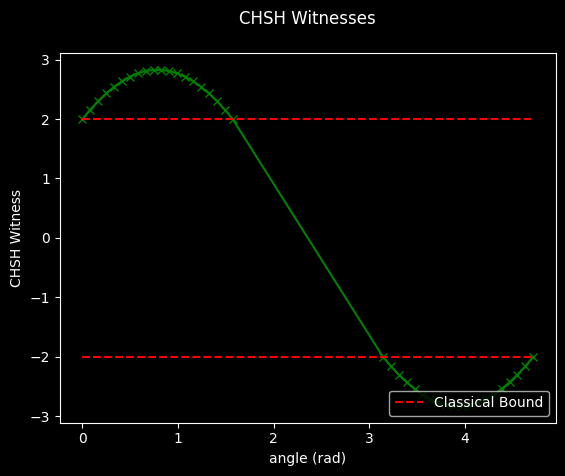

In [21]:
# crate an Estimator object
estimator = Estimator()

# create a job for the quantum circuit implementing
# a parametrized quantum entangled pair,
# varying the elements in the list of
# theta angles defined before
job = estimator.run( [qc] * len(angles),
                     observables=[obsv] * len(angles),
                     parameter_values=angles )


# retrieve the expectation values
# from the results of the job ran by
# the Estimator created before,
# that was ran on the parametrized
# quantum entangled pair
exps = job.result().values


# plot the angles theta parametrized from the list built before
plt.plot( angles, exps, marker='x', ls='-', color="green" )

# plot the two classical bounds that violates the CHSH inequality
plt.plot( angles, [2]*len(angles), ls="--", color="red", label="Classical Bound" )
plt.plot( angles, [-2]*len(angles), ls="--", color="red" )


# add the X-axis label to the plot built before
plt.xlabel("angle (rad)")

# add the Y-axis label to the plot built before
plt.ylabel("CHSH Witness")


# add the title to the plot built before
plt.title("CHSH Witnesses\n")


# add the legend to the plot built before
plt.legend(loc=4)

Did you see at least 3 points outside the red dashed lines? If so, you are ready to send to the grader!

In [22]:
# import the grader for the exercise 2 of the lab 2
from qc_grader.challenges.qgss_2023 import grade_lab2_ex2

# grade the exercise 2 of the lab 2
grade_lab2_ex2( obsv, angles )

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# Teleportation

Quantum information cannot be copied due to the *No Cloning Theorem*, however it can be "teleported" in the sense that a qubit can be entangled with a quantum resource, and via a protocol of measurements and *classical communication* of their results, the original quantum state can be reconstructed on a different qubit. This process destroys the information in the original qubit via measurement.

In this exercise, we will construct a particular qubit state and then transfer that state to another qubit using the teleportation protocol. Here we will be looking at specific classical and quantum registers, so we need to import those.

In [23]:
from qiskit.circuit import ClassicalRegister, QuantumRegister

### Create the circuit

Define an angle $\theta$ to rotate our qubit by. This will allow us to easily make comparisons for the original state and the teleported state.

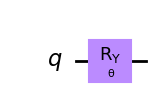

In [24]:
# create a parameter for the theta angle
theta = Parameter("θ")


# create a quantum register for one qubit
# and to implement a parametrized quantum operation
qr = QuantumRegister(1, "q")

# create a quantum circuit with
# the quantum register created before
qc = QuantumCircuit(qr)


# apply a RY (Rotation-Y) gate to
# the quantum circuit, on the 1st qubit,
# with the theta angle defined before
qc.ry(theta, 0)


# draw the quantum circuit implementing
# a parametrized quantum operation
qc.draw("mpl")

Alice possesses the quantum information $|\psi\rangle$ in the state of $q$ and wishes to transfer it to Bob. The resource they share is a special entangled state called a Bell state
$$
|\Phi^+\rangle = \frac{1}{2} \left( |00\rangle + |11\rangle \right)
$$
with the first of the pair going to Alice and the second to Bob. Hence Alice has a 2-qubit register ($q$ and $Bell_0$) and Bob has a single-qubit register ($Bell_1$). We will construct the circuit by copying the original `qc` and adding the appropriate registers.

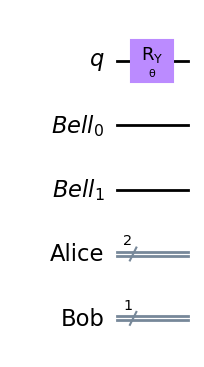

In [25]:
# create a copy of the quantum circuit defined before
# to initialize the quantum circuit implementing
# a parametrized quantum teleportation
tele_qc = qc.copy()


# create a quantum register with two qubits
# for the Bell State to be shared on
# the parametrized quantum teleportation
bell = QuantumRegister(2, "Bell")

# create a classical register with two qubits
# for Alice's part on the parametrized
# quantum teleportation
alice = ClassicalRegister(2, "Alice")

# create a classical register with one qubit
# for Bob's part on the parametrized
# quantum teleportation
bob = ClassicalRegister(1, "Bob")


# add all the quantum and classical registers
# created before to the quantum circuit implementing
# a parametrized quantum teleportation
tele_qc.add_register(bell, alice, bob)


# draw the quantum circuit implementing
# the 1st step of a parametrized
# quantum teleportation
tele_qc.draw("mpl")

Now create the Bell pair with $Bell_0$ going to Alice and $Bell_1$ going to Bob. This is done by using a Hadamard gate to put $Bell_0$ in the $|+\rangle$ state and then performing a CNOT with the same qubit as the control. After they receive their respective qubit, they part ways.

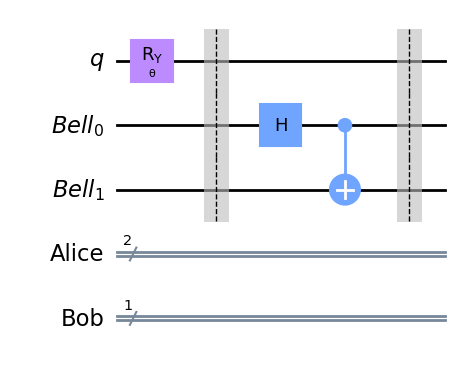

In [26]:
# add a barrier to the quantum circuit implementing
# a parametrized quantum teleportation
tele_qc.barrier()


# create Bell state with the other two qubits,
# in the quantum register defined before
# for that purpose

# apply a Hadamard gate to
# the quantum circuit, on the 2nd qubit
tele_qc.h(1)

# apply a CX/CNOT gate to
# the quantum circuit,
# with control on 2nd qubit
# and target on 3rd qubit
tele_qc.cx(1, 2)


# add a barrier to the quantum circuit implementing
# a parametrized quantum teleportation
tele_qc.barrier()


# draw the quantum circuit implementing
# the 2nd step of a parametrized
# quantum teleportation
tele_qc.draw("mpl")

Next, Alice performs a CNOT controlled by $q$ on $Bell_0$, which maps information about the state onto it. She then applies a Hadamard gate on $q$.

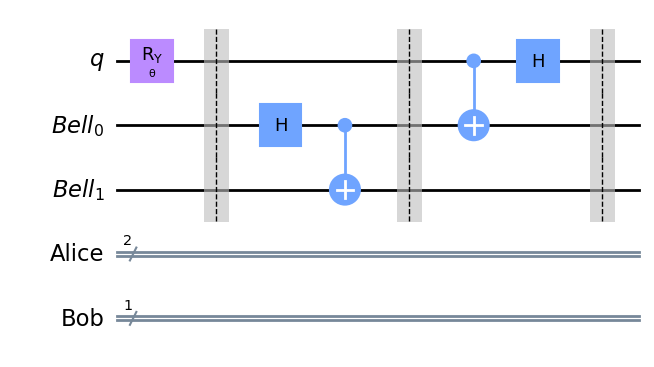

In [27]:
# operations for Alice perform on her qubits
# during the parametrized quantum teleportation

# apply a CX/CNOT gate to
# the quantum circuit,
# with control on 1sr qubit
# and target on 2nd qubit
tele_qc.cx(0, 1)

# apply a Hadamard gate to
# the quantum circuit, on the 1st qubit
tele_qc.h(0)


# add a barrier to the quantum circuit implementing
# a parametrized quantum teleportation
tele_qc.barrier()

# draw the quantum circuit implementing
# the 3rd step of a parametrized
# quantum teleportation
tele_qc.draw("mpl")

Now Alice measures her qubits and saves the results to her register.

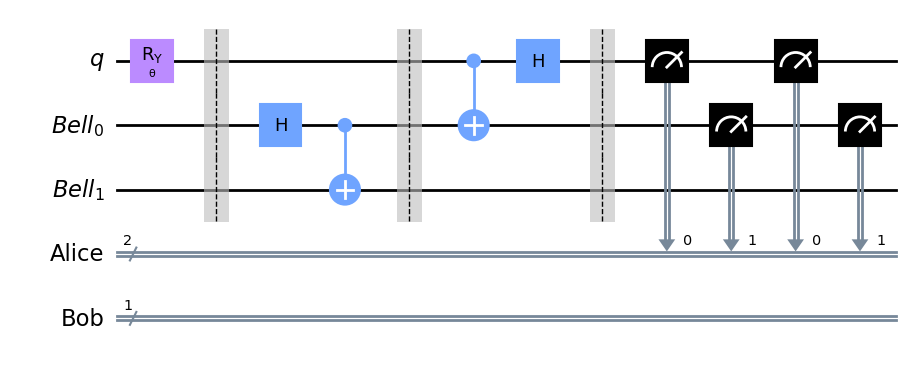

In [29]:
# measurements performed by Alice on
# the qubit q and on her part of the Bell State,
# performing the entanglement swapping
tele_qc.measure( [ qr[0], bell[0] ], alice )

# draw the quantum circuit implementing
# the 4th step of a parametrized
# quantum teleportation
tele_qc.draw("mpl")

Bob's qubit now has the information $|\psi\rangle$ from Alice's qubit $q$ encoded in $Bell_1$, but he does not know what basis to measure in to extract it. Accordingly, Alice must share the information in her register over a *classical* communication channel (this is why teleportation does not violate special relativity, no matter how far Alice and Bob are apart). She instructs Bob to perform an X gate on his qubit if her measurement of $Bell_0$ yields a 1 outcome, followed by a Z gate if her measurement of $q$ yields a 1.

The applications of these gates can be conditioned on the measurement outcomes in two ways:
- the `.c_if()` [instruction](https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html), which applies the gate it modifies if the value of the `ClassicalRegister` index is equal to the value specified. Note that this works **only** on simulators.
- the `.if_test()` [context](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) which operates similarly, but generalizes the syntax to allow for nested conditionals. This works on both simulators and actual hardware.

Ex 3 - Add approriate conditional gates to transform Bob's qubit into the $Z$-basis.

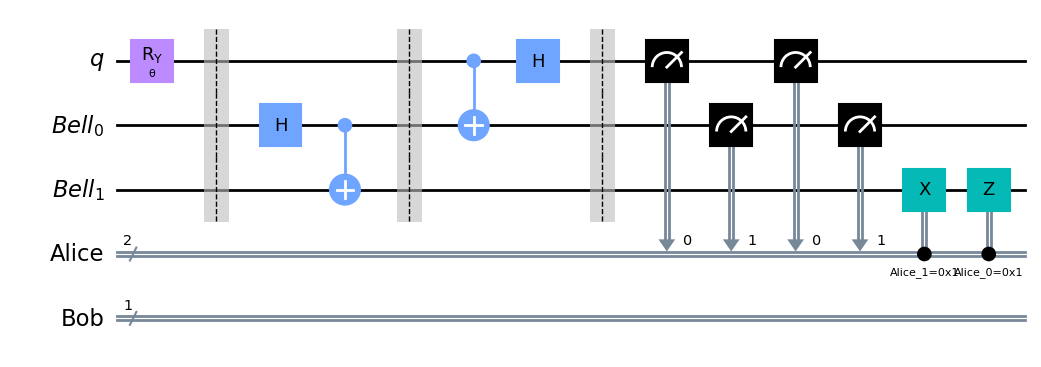

In [30]:
# create a copy of the quantum circuit defined before
# to initialize the quantum circuit implementing
# a parametrized quantum teleportation,
# and to be graded with dynamic operations 
graded_qc = tele_qc.copy()


##############################

# add gates to graded_qc here

# Bob, who already has the qubit teleported,
# applies the following gates depending on
# the state of the classical bits:
# 00 -> Do nothing
# 01 -> Apply X gate
# 10 -> Apply Z gate
# 11 -> Apply ZX gate

# apply the Pauli-X (bit flip / not) gate on
# the 2nd qubit of the Bell state if
# the Alice's 2nd classical bit is 1
graded_qc.x( bell[1] ).c_if( alice[1], 1 )

# apply the Pauli-Z (phase flip) gate on
# the 2nd qubit of the Bell state if
# the Alice's 1st classical bit is 1
graded_qc.z( bell[1] ).c_if( alice[0], 1 )

##############################


# draw the quantum circuit implementing
# the parametrized quantum teleportation, to be graded
graded_qc.draw("mpl")


Finally, Bob can measure his qubit, which would yield results with the same probabilities as had Alice measured it originally.

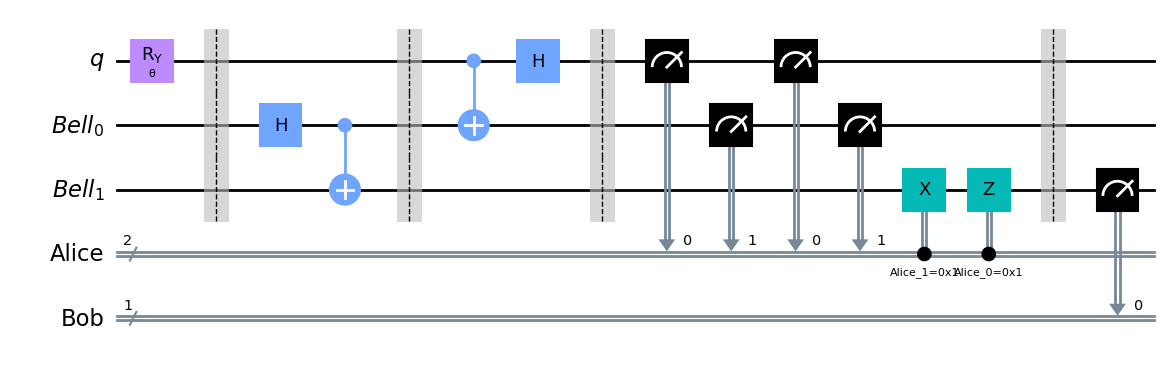

In [31]:
# add a barrier to the quantum circuit implementing
# a parametrized quantum teleportation, to be graded
graded_qc.barrier()


# measure the 2nd qubit of the Bell state to
# the Bob's classical register
graded_qc.measure( bell[1], bob )


# draw the quantum circuit implementing
# a parametrized quantum teleportation, to be graded
graded_qc.draw("mpl")

In [32]:
# import the grader for the exercise 3 of the lab 2
from qc_grader.challenges.qgss_2023 import grade_lab2_ex3

# grade the exercise 3 of the lab 2
grade_lab2_ex3( graded_qc, theta, 5 * ( np.pi / 7 ) )

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


# The statevector simulator cannot work with dynamic circuits because measurement is not a unitary operation. Therefore we import the `Sampler` primitive from `qiskit_aer` to use the `AerSimulator`. We choose our angle to be $5\pi/7$, which will yield a 1 result about 80\% of the time and 0 result about 20\% of the time. Then we run both circuits: the original one Alice had and the teleported one Bob receives. 

In [33]:
# impor the Sampler from the IBM's Qiskit
# Aer primitives module
from qiskit_aer.primitives import Sampler


# define the pretended theta angle
angle = 5 * ( np.pi / 7 ) 


# create a Sampler object
sampler = Sampler()


# measure all the qubits on the quantum circuit
# implementing a parametrized quantum teleportation
qc.measure_all()


# create a job for the quantum circuit implementing
# a parametrized quantum teleportation,
# with a static quantum circuit and
# with the theta angle defined before
job_static = sampler.run( qc.bind_parameters({theta: angle}) )

# create a job for the quantum circuit implementing
# a parametrized quantum teleportation,
# with a dynamic quantum circuit and
# with the theta angle defined before
job_dynamic = sampler.run( graded_qc.bind_parameters({theta: angle}) )


# print the measurement distributions of the qubits from
# the parametrized quantum teleportation, with a static quantum circuit
print( f"Original Dists.: {job_static.result().quasi_dists[0].binary_probabilities()}" )

# print the measurement distributions of the qubits from
# the parametrized quantum teleportation, with a dynamic quantum circuit
print( f"Teleported Dists.: {job_dynamic.result().quasi_dists[0].binary_probabilities()}" )

Original Dists.: {'0': 0.1884765625, '1': 0.8115234375}
Teleported Dists.: {'001': 0.048828125, '110': 0.19140625, '011': 0.04296875, '111': 0.208984375, '100': 0.197265625, '000': 0.0537109375, '010': 0.044921875, '101': 0.2119140625}


Wait, we see different results! While measuring Alice's original $q$ yields the expected ratio of outcomes, the teleported distributions have many more values. This is because the teleported circuit includes Alice's measurements of $q$ and $Bell_0$, whereas we only wish to see Bob's measurements of $Bell_1$ yield the same distribution. 

In order to rectify this, we must take the *marginal* counts, meaning we combine results in which Bob measures a 0 and all the results in which Bob measures a 1 over all the possible combinations. This is done with the `marginal_counts` [method](https://qiskit.org/documentation/stubs/qiskit.result.marginal_counts.html) from `qiskit.result`, which combines results over measurement indices.

Ex 4 - Marginalize the teleported counts

Hint: Remember that bit strings are reported in the little-endian convention.

In [34]:
# import the counts marginalization from
# the IBM's Qiskit result module
from qiskit.result import marginal_counts

# marginalize counts from the quasi-distributitions
# obtained from the parametrized quantum teleportation
tele_counts = marginal_counts( job_dynamic.result().quasi_dists[0]
                               .binary_probabilities(), [2] )

If we marginalized correctly, we will see that the quasi-distributions from Alice's measurement and Bob's measurement are nearly identical, demonstrating that teleportation was successful!

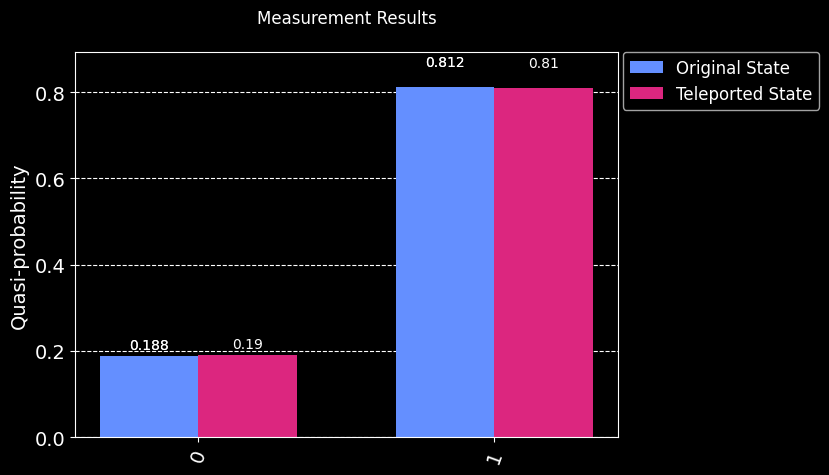

In [35]:
# create the legend for the two quantum states
# created before, namely the original quantum state to
# be teleported and the quantum state which was indeed teleported
legend = [ "Original State", "Teleported State" ]

# plot the histogram for the quasi-distributions
# for the two quantum states created before,
# namely the original quantum state to be teleported
# and the quantum state which was indeed teleported
plot_histogram( [ job_static.result().quasi_dists[0]
                  .binary_probabilities(), tele_counts ],
                legend=legend, title="Measurement Results\n" )

In [36]:
# import the grader for the exercise 4 of the lab 2
from qc_grader.challenges.qgss_2023 import grade_lab2_ex4

# grade the exercise 4 of the lab 2
grade_lab2_ex4( tele_counts, job_dynamic.result() )

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [37]:
import qiskit.tools.jupyter
%qiskit_version_table